# Process "Census Skills" Question Using a LLM

Andrew Weng, 12/30/2024

We are going to use a mixed LLM-Python approach to solve the problem of "user text categorization."

This problem can be decomposed into five steps:

1. Pre-process (LLM1)
 - Each user provides up to three keywords as a string. These keywords need to be normalized and stored in a large list of individual keywords for the next stage.
2. Define categories (LLM2)
 - With the list of keywords, find the best set of categories to describe the keywords
3. Assign categories (LLM3)
 - For each keyword, assign it to a category. Be careful about how to handle exceptions (e.g., a keyword that doesn't seem to belog into any particular category.)
4. Count occurences (Python)
 - Within each category, sum up the total number of keywords. 
5. Visualize the results (Python)

In [1]:
import os
import time

current_folder = os.path.basename(os.getcwd())
if current_folder == 'notebooks':
    root_path = os.path.dirname(os.path.abspath(''))
    os.chdir(root_path)

from src.analyst import Analyst
from src.plotter import Plotter
from src.llm import LLM

from collections import defaultdict

import pickle
from pprint import pprint

from IPython import get_ipython
# Automatically reload all modules every time a line of code is executed
get_ipython().run_line_magic('load_ext', 'autoreload')
get_ipython().run_line_magic('autoreload', '2')

# Initialize our helper classes

In [2]:
analyst = Analyst()
analyst.load_data()
analyst.build_respondents_list()

plotter = Plotter()
llm = LLM()

# Fetch the relevant dataset to analyze

In [ ]:
question = dict()

question['tag'] = 'census_skills'

question['question'] = "In your opinion, what are the top three skills most in demand in the battery industry?"

question['categories'] = ['Battery Chemistry / Electrochemistry',
 'Materials Science and Characterization',
 'Battery Design',
 'Battery Manufacturing / Scale-up / Process Engineering',
 'Battery Testing / Failure Analysis / Quality Control',
 'Battery Management Systems (BMS)',
 'Data Science / Data Analysis / AI / Machine Learning',
 'Modeling / Simulation / Computational Tools',
 'Electrical Engineering / Power Electronics',
 'Thermal Management',
 'Programming / Software Development',
 'Project Management / Leadership / Teamwork',
 'Communication / Presentation Skills / Language Skills',
 'Business Skills / Marketing / Strategy / Market Knowledge',
 'Supply Chain / Logistics / Procurement',
 'Innovation / Creativity / Problem Solving',
 'Safety / Standards / Regulations / Compliance',
 'Soft Skills (e.g., flexibility, adaptability, resilience)',
 'Environmental Knowledge / Sustainability / Recycling',
 'Interdisciplinary / Cross-functional Collaboration']

question['data'] = analyst.summarize_census_skills_demand()['skills_in_demand']

pprint(question['data'])

['Scale up, the ability to keep up with and foresee research/industry trends '
 'and directions, language abilities (Chinese, Korean, Japanese) to learn from '
 'the bigger battery markets',
 'Design for Reliability,   Test',
 'Agile, Innovative, Communication',
 'design, manufacturing, and testing',
 'Electrochemistry, Process, Data Analysis',
 'Scientific Observation, Data Analysis, ability to contribute to a team',
 'Data analysis; research and experimentation; presentation skills',
 'data science, manufacturing, pouch cells',
 'Technical Knowledge; Software; Entrepreneurship',
 'BMS, Safety, and process engineer',
 '[cell knowledge]',
 'Electrical knowledge / organisational skills / poise',
 'Manufacturing scale-up',
 'Knowledge, Research, Analytical Power',
 'MATLAB optimisation 1; COMSOL 2;',
 'Skill 1 - Cell Engineering (R&D and Mature Products), Skill 2 - Product '
 'Pricing/Cost Engineering, Skill 3 - Strategic Partnership',
 'software/programming   battery chemistry design   

# Pre-process the user response

Interpret the delimiters

In [ ]:
keyword_list = []

for i, string_of_list in enumerate(question['data']):
    print(f"Processing response {i+1} of {len(question['data'])}")
    list_of_strings = llm.delimit_string_of_list(string_of_list)
    print(f'--> {list_of_strings}\n')
    keyword_list.extend(list_of_strings)

# Assemble and cache the list
print(keyword_list)
timestamp = time.strftime('%Y%m%d_%H%M%S')
with open(f'data/strlist_{question['tag']}_{timestamp}.pkl', 'wb') as f:
    pickle.dump(keyword_list, f)

Processing response 1 of 1000
--> ['Scale up', 'ability to keep up with and foresee research/industry trends and directions', 'language abilities (Chinese, Korean, Japanese)']

Processing response 2 of 1000
--> ['Design for Reliability', 'Test']

Processing response 3 of 1000
--> ['Agile', 'Innovative', 'Communication']

Processing response 4 of 1000
--> ['design', 'manufacturing', 'testing']

Processing response 5 of 1000
--> ['Electrochemistry', 'Process', 'Data Analysis']

Processing response 6 of 1000
--> ['Scientific Observation', 'Data Analysis', 'ability to contribute to a team']

Processing response 7 of 1000
--> ['Data analysis', 'research and experimentation', 'presentation skills']

Processing response 8 of 1000
--> ['data science', 'manufacturing', 'pouch cells']

Processing response 9 of 1000
--> ['Technical Knowledge', 'Software', 'Entrepreneurship']

Processing response 10 of 1000
--> ['BMS', 'Safety', 'process engineer']

Processing response 11 of 1000
--> ['cell knowle

# Define categories

In [4]:
if question['categories'] == []:
    categories = llm.define_categories(question['question'], keyword_list,
                                   num_categories=50)

    category_list = []
    for category in categories['categories']:
        category_list.append(category['name'])

else:
    category_list = question['categories']

pprint(category_list)

['Battery Chemistry / Electrochemistry',
 'Materials Science and Characterization',
 'Battery Design',
 'Battery Manufacturing / Scale-up / Process Engineering',
 'Battery Testing / Failure Analysis / Quality Control',
 'Battery Management Systems (BMS)',
 'Data Science / Data Analysis / AI / Machine Learning',
 'Modeling / Simulation / Computational Tools',
 'Electrical Engineering / Power Electronics',
 'Thermal Management',
 'Programming / Software Development',
 'Project Management / Leadership / Teamwork',
 'Communication / Presentation Skills / Language Skills',
 'Business Skills / Marketing / Strategy / Market Knowledge',
 'Supply Chain / Logistics / Procurement',
 'Innovation / Creativity / Problem Solving',
 'Safety / Standards / Regulations / Compliance',
 'Soft Skills (e.g., flexibility, adaptability, resilience)',
 'Environmental Knowledge / Sustainability / Recycling',
 'Interdisciplinary / Cross-functional Collaboration']


# Assign categories

Process one keyword at a time!

In [7]:
content_list = []
other_list = []
fail_list = []

for i, keyword in enumerate(keyword_list):

    print(f"Categorizing '{keyword}' ({i+1} of {len(keyword_list)})...")

    try:
        output = llm.classify_user_response(category_list, keyword)
    except: # JSON output fails
        print(f"Failed to process response: '{keyword}'")
        fail_list.append(keyword)
        continue

    if output['result']['category'] in category_list:
        content_list.append(output)
    else:
        other_list.append(output)

Processing response: 'Scale up' (1 of 2739)...
Processing response: 'ability to keep up with and foresee research/industry trends and directions' (2 of 2739)...
Processing response: 'language abilities (Chinese, Korean, Japanese)' (3 of 2739)...
Processing response: 'Design for Reliability' (4 of 2739)...
Processing response: 'Test' (5 of 2739)...
Processing response: 'Agile' (6 of 2739)...
Processing response: 'Innovative' (7 of 2739)...
Processing response: 'Communication' (8 of 2739)...
Processing response: 'design' (9 of 2739)...
Processing response: 'manufacturing' (10 of 2739)...
Processing response: 'testing' (11 of 2739)...
Processing response: 'Electrochemistry' (12 of 2739)...
Processing response: 'Process' (13 of 2739)...
Processing response: 'Data Analysis' (14 of 2739)...
Processing response: 'Scientific Observation' (15 of 2739)...
Processing response: 'Data Analysis' (16 of 2739)...
Processing response: 'ability to contribute to a team' (17 of 2739)...
Processing respons

In [8]:
print(len(other_list))

311


In [9]:
other_list

[{'result': {'response_text': 'Scientific Observation', 'category': 'Other'}},
 {'result': {'response_text': 'Technical Knowledge', 'category': 'Other'}},
 {'result': {'response_text': 'Knowledge', 'category': 'Other'}},
 {'result': {'response_text': 'integration instead of verticality',
   'category': 'Other'}},
 {'result': {'response_text': 'Technical background', 'category': 'Other'}},
 {'result': {'response_text': 'abstraction', 'category': 'Other'}},
 {'result': {'response_text': 'engineering', 'category': 'Other'}},
 {'result': {'response_text': 'small molecule development',
   'category': 'Other'}},
 {'result': {'response_text': 'technical knowledge', 'category': 'Other'}},
 {'result': {'response_text': 'Physics', 'category': 'Other'}},
 {'result': {'response_text': 'Engineering', 'category': 'Other'}},
 {'result': {'response_text': 'Systems', 'category': 'Other'}},
 {'result': {'response_text': 'learning', 'category': 'Other'}},
 {'result': {'response_text': 'Systems Engineerin

In [10]:
print(len(fail_list))

13


## Assembly dictionary for plotting and a 'collection' dictionary

The 'collection' is a reference for which keywords got sorted into which categories.

In [ ]:
collection = defaultdict(list)
counter    = defaultdict(int)

for content in content_list:

    category = content['result']['category']
    response = content['result']['response_text']
    counter[category] += 1
    collection[category].append(response)

counter['_tot_'] = len(question['data'])
counter

defaultdict(int,
            {'Battery Manufacturing / Scale-up / Process Engineering': 306,
             'Business Skills / Marketing / Strategy / Market Knowledge': 186,
             'Communication / Presentation Skills / Language Skills': 100,
             'Battery Design': 121,
             'Battery Testing / Failure Analysis / Quality Control': 172,
             'Project Management / Leadership / Teamwork': 134,
             'Innovation / Creativity / Problem Solving': 191,
             'Battery Chemistry / Electrochemistry': 209,
             'Data Science / Data Analysis / AI / Machine Learning': 198,
             'Programming / Software Development': 67,
             'Battery Management Systems (BMS)': 52,
             'Safety / Standards / Regulations / Compliance': 58,
             'Electrical Engineering / Power Electronics': 56,
             'Soft Skills (e.g., flexibility, adaptability, resilience)': 182,
             'Modeling / Simulation / Computational Tools': 100,
   

In [12]:
collection

defaultdict(list,
            {'Battery Manufacturing / Scale-up / Process Engineering': ['Scale up',
              'manufacturing',
              'Process',
              'manufacturing',
              'process engineer',
              'Manufacturing scale-up',
              'Manufacturing Basics',
              'electrode fabrication experience',
              'hands-on experience building cells',
              'Process Engineering',
              'Equipment Engineering',
              'scale up for production',
              'Skilled battery techs',
              'Cell manufacturing',
              'Manufacturing Experience',
              'cell fabrication',
              'cell manufacturing process ramp-up',
              'Strong manufacturing knowledge',
              'Manufacturing',
              'Manufacturing and automation engineering',
              'pack-level assembly',
              'Manufacturing',
              'Gigafactory manufacturing experience',
              'Pro

# Visualize the results

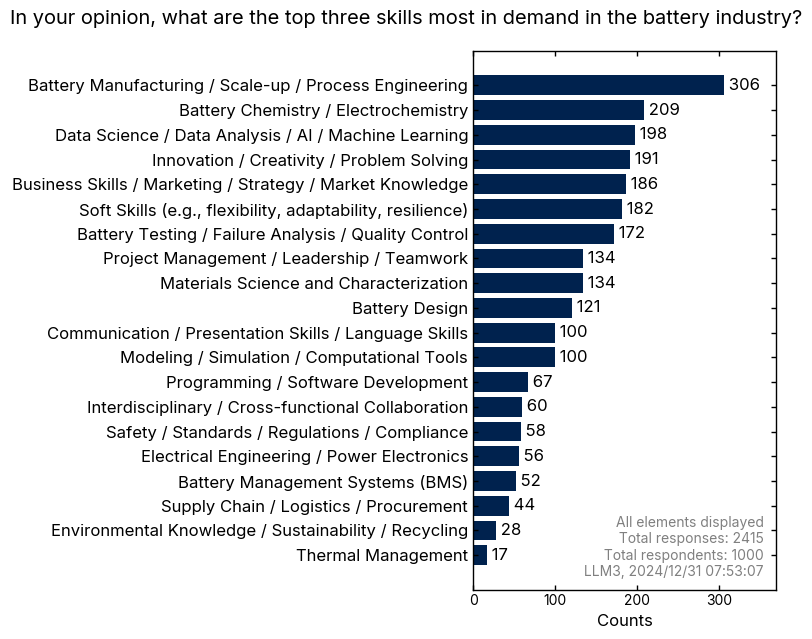

In [13]:
plotter.make_bar_plot_from_dict(counter,
                                title=question['question'],
                                sorted=True,
                                annotation=f'LLM3, {time.strftime("%Y/%m/%d %H:%M:%S")}',
                                num_elements=100,
                                saveas=f'{question['tag']}_{time.strftime("%Y%m%d_%H%M%S")}.png'
)

# Now do it all again, but this time filtering for senior IC roles and managers

These are people who generally participate in recruiting.

Include Senior/Expert/Manager/Director/VP/Executive.

Include those currently working or used to work.

In [5]:
respondents = analyst.respondents_list
respondents

working_list = [] # includes unemployed but previously working
working_and_recruiting_list = [] # those who are working and participate in recruiting
student_list = []

for respondent in analyst.respondents_list:

    if respondent.is_working or respondent.is_unemployed:

        working_list.append(respondent)

        if respondent.company['role_level'] in ['Senior', 'Expert', 'Manager', 'Director/VP', 'Executive']:
            working_and_recruiting_list.append(respondent)

    if respondent.is_student:
        student_list.append(respondent)

print(f'Number of working respondents: {len(working_list)}')
print(f'Number of working respondents who also participate in recruiting: {len(working_and_recruiting_list)}')
print(f'Number of student respondents: {len(student_list)}')

Number of working respondents: 937
Number of working respondents who also participate in recruiting: 487
Number of student respondents: 86


In [6]:
question['data'] = analyst.summarize_census_skills_demand(working_and_recruiting_list)['skills_in_demand']
pprint(question['data'])

['Scale up, the ability to keep up with and foresee research/industry trends '
 'and directions, language abilities (Chinese, Korean, Japanese) to learn from '
 'the bigger battery markets',
 'Design for Reliability,   Test',
 'design, manufacturing, and testing',
 'BMS, Safety, and process engineer',
 'Knowledge, Research, Analytical Power',
 'Skill 1 - Cell Engineering (R&D and Mature Products), Skill 2 - Product '
 'Pricing/Cost Engineering, Skill 3 - Strategic Partnership',
 'software/programming   battery chemistry design    testing',
 'Long term vision and planning skills. Product knowledge. People '
 'communication',
 'failure analysis; techno-economic analysis; codes/standards',
 'Battery Health Estimation Algorithm, Battery Field Systems Engineering, '
 'Battery Cost and Estimation Expertise',
 'Design process test',
 'Battery code and standards, Battery products strategy and management,Battery '
 'system design and operation,',
 'Communications; integration instead of vertica

In [7]:
# Check if there are existing files with similar names
existing_files = [f for f in os.listdir('data') if f.startswith(f'strlist_{question["tag"]}_recruiters_')]

if existing_files:
    # Load the most recent file
    latest_file = max(existing_files)
    with open(f'data/{latest_file}', 'rb') as f:
        keyword_list = pickle.load(f)

else:

    keyword_list = []

    for i, string_of_list in enumerate(question['data']):
        print(f"Processing response {i+1} of {len(question['data'])}")
        list_of_strings = llm.delimit_string_of_list(string_of_list)
        print(f'--> {list_of_strings}\n')
        keyword_list.extend(list_of_strings)

    # Assemble and cache the list
    print(keyword_list)
    timestamp = time.strftime('%Y%m%d_%H%M%S')
    with open(f'data/strlist_{question['tag']}_recruiters_{timestamp}.pkl', 'wb') as f:
        pickle.dump(keyword_list, f)

keyword_list

['Scale up',
 'ability to keep up with and foresee research/industry trends and directions',
 'language abilities (Chinese, Korean, Japanese)',
 'Design for Reliability',
 'Test',
 'design',
 'manufacturing',
 'testing',
 'BMS',
 'Safety',
 'process engineer',
 'Knowledge',
 'Research',
 'Analytical Power',
 'Cell Engineering (R&D and Mature Products)',
 'Product Pricing/Cost Engineering',
 'Strategic Partnership',
 'software/programming',
 'battery chemistry design',
 'testing',
 'Long term vision and planning skills',
 'Product knowledge',
 'People communication',
 'failure analysis',
 'techno-economic analysis',
 'codes/standards',
 'Battery Health Estimation Algorithm',
 'Battery Field Systems Engineering',
 'Battery Cost and Estimation Expertise',
 'Design process',
 'test',
 'Battery code and standards',
 'Battery products strategy and management',
 'Battery system design and operation',
 'Communications',
 'integration instead of verticality',
 'Technical background',
 'customer

In [8]:
content_list = []
other_list = []
fail_list = []

for i, keyword in enumerate(keyword_list):

    print(f"Categorizing '{keyword}' ({i+1} of {len(keyword_list)})...")

    try:
        output = llm.classify_user_response(category_list,
                                            keyword,
                                            model='gpt-4o')
    except: # JSON output fails
        print(f"Failed to process response: '{keyword}'")
        fail_list.append(keyword)
        continue

    if output['result']['category'] in category_list:
        content_list.append(output)
    else:
        other_list.append(output)

Categorizing 'Scale up' (1 of 1280)...
Categorizing 'ability to keep up with and foresee research/industry trends and directions' (2 of 1280)...
Categorizing 'language abilities (Chinese, Korean, Japanese)' (3 of 1280)...
Categorizing 'Design for Reliability' (4 of 1280)...
Categorizing 'Test' (5 of 1280)...
Categorizing 'design' (6 of 1280)...
Categorizing 'manufacturing' (7 of 1280)...
Categorizing 'testing' (8 of 1280)...
Categorizing 'BMS' (9 of 1280)...
Categorizing 'Safety' (10 of 1280)...
Categorizing 'process engineer' (11 of 1280)...
Categorizing 'Knowledge' (12 of 1280)...
Categorizing 'Research' (13 of 1280)...
Categorizing 'Analytical Power' (14 of 1280)...
Categorizing 'Cell Engineering (R&D and Mature Products)' (15 of 1280)...
Categorizing 'Product Pricing/Cost Engineering' (16 of 1280)...
Categorizing 'Strategic Partnership' (17 of 1280)...
Categorizing 'software/programming' (18 of 1280)...
Categorizing 'battery chemistry design' (19 of 1280)...
Categorizing 'testing' 

In [9]:
collection = defaultdict(list)
counter    = defaultdict(int)

for content in content_list:

    category = content['result']['category']
    response = content['result']['response_text']
    counter[category] += 1
    collection[category].append(response)

counter['_tot_'] = len(question['data'])
counter

defaultdict(int,
            {'Battery Manufacturing / Scale-up / Process Engineering': 185,
             'Business Skills / Marketing / Strategy / Market Knowledge': 119,
             'Communication / Presentation Skills / Language Skills': 47,
             'Battery Design': 67,
             'Battery Testing / Failure Analysis / Quality Control': 70,
             'Battery Management Systems (BMS)': 32,
             'Safety / Standards / Regulations / Compliance': 37,
             'Data Science / Data Analysis / AI / Machine Learning': 77,
             'Programming / Software Development': 18,
             'Project Management / Leadership / Teamwork': 60,
             'Interdisciplinary / Cross-functional Collaboration': 41,
             'Innovation / Creativity / Problem Solving': 77,
             'Soft Skills (e.g., flexibility, adaptability, resilience)': 83,
             'Battery Chemistry / Electrochemistry': 91,
             'Modeling / Simulation / Computational Tools': 30,
    

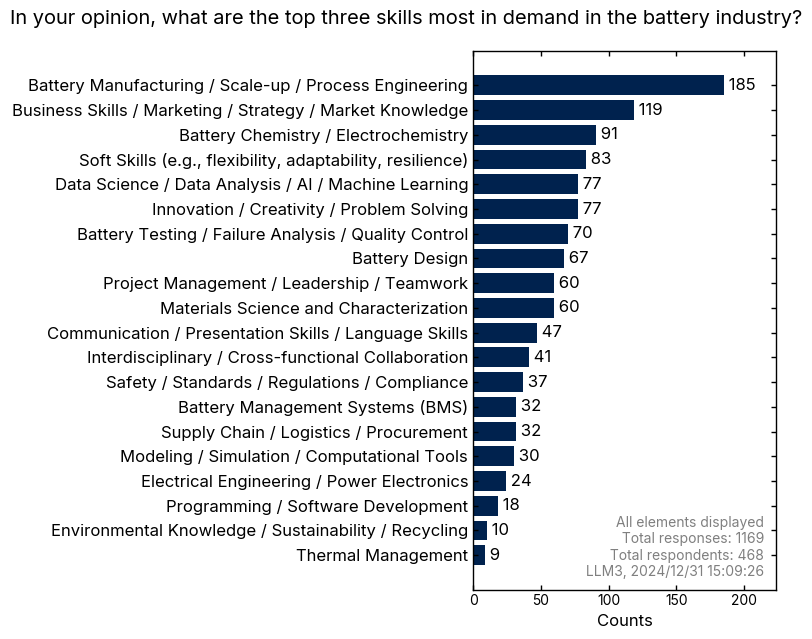

In [10]:
plotter.make_bar_plot_from_dict(counter,
                                title=question['question'],
                                sorted=True,
                                annotation=f'LLM3, {time.strftime("%Y/%m/%d %H:%M:%S")}',
                                num_elements=100,
                                saveas=f'{question['tag']}_recruiters_{time.strftime("%Y%m%d_%H%M%S")}.png'
)

# What if students defined the categories?

In [ ]:
question['data'] = analyst.summarize_census_skills_demand(student_list)['skills_in_demand']
pprint(question['data'])

question['categories'] = ['Electrochemistry / Battery Chemistry',
 'Materials Science / Materials Engineering',
 'Manufacturing / Process Engineering',
 'Data Analysis / Statistics',
 'Machine Learning / AI / Modeling / Simulations',
 'Programming / Software Development / Coding',
 'Battery Testing / Characterization Techniques / Diagnostics',
 'Battery Management Systems (BMS) / Controls',
 'Thermal Management',
 'Recycling / Sustainability',
 'Hardware Knowledge / Equipment Proficiency',
 'Safety Knowledge / Safety Testing',
 'Supply Chain / Logistics / Procurement',
 'Communication Skills / Presentation Skills',
 'Teamwork / Collaboration / Mentorship',
 'Leadership / Management / Planning',
 'Problem Solving / Critical Thinking / Creativity / Troubleshooting',
 'Learning / Adaptability / Staying Updated',
 'Networking',
 'General Knowledge / Experience / Expertise']

keyword_list = []

for i, string_of_list in enumerate(question['data']):
    print(f"Processing response {i+1} of {len(question['data'])}")
    list_of_strings = llm.delimit_string_of_list(string_of_list)
    print(f'--> {list_of_strings}\n')
    keyword_list.extend(list_of_strings)

# Assemble and cache the list
print(keyword_list)
timestamp = time.strftime('%Y%m%d_%H%M%S')
with open(f'data/strlist_{question['tag']}_students_{timestamp}.pkl', 'wb') as f:
    pickle.dump(keyword_list, f)


['Manufacturing scale-up',
 'Material Synthesis, Material Characterization, Data Analysis,',
 'Data analysis, statistics, communication',
 'Skill 1: Good knowledge about science of batteries, Skill 2: Familiarity '
 'with new approaches such as AI and Machine Learning, Skill 3: Networking and '
 'communication skills',
 'troubleshooting, learning, communication',
 'Electrochemistry. Data Analysis. Data Presentation',
 'I think that polymer science fundamentals are under appreciated in the '
 'battery space',
 'Manufacturing; AI optimization; Safety testing',
 '"electrochemistry fundamentals; AI methods; interdiscipinarys"',
 'Battery Management Systems, Battery Modeling, Battery Charging, Battery '
 'Thermal Controls',
 'Material Characterization; Programming; Hardware Knowledge',
 'Materials knowledge; research experience; understanding of basic science',
 'Characterizstion;testing;syntheshis',
 'Coding; Electrochemistry knowledge',
 'data analysis',
 '"Fundamental knowledge of the el

In [14]:
categories = llm.define_categories(question['question'], keyword_list,
                                num_categories=20)

category_list = []
for category in categories['categories']:
    category_list.append(category['name'])


pprint(category_list)

['Electrochemistry / Battery Chemistry',
 'Materials Science / Materials Engineering',
 'Manufacturing / Process Engineering',
 'Data Analysis / Statistics',
 'Machine Learning / AI / Modeling / Simulations',
 'Programming / Software Development / Coding',
 'Battery Testing / Characterization Techniques / Diagnostics',
 'Battery Management Systems (BMS) / Controls',
 'Thermal Management',
 'Recycling / Sustainability',
 'Hardware Knowledge / Equipment Proficiency',
 'Safety Knowledge / Safety Testing',
 'Supply Chain / Logistics / Procurement',
 'Communication Skills / Presentation Skills',
 'Teamwork / Collaboration / Mentorship',
 'Leadership / Management / Planning',
 'Problem Solving / Critical Thinking / Creativity / Troubleshooting',
 'Learning / Adaptability / Staying Updated',
 'Networking',
 'General Knowledge / Experience / Expertise']


## Assign categories

In [15]:
content_list = []
other_list = []
fail_list = []

for i, keyword in enumerate(keyword_list):

    print(f"Categorizing '{keyword}' ({i+1} of {len(keyword_list)})...")

    try:
        output = llm.classify_user_response(category_list,
                                            keyword,
                                            model='gpt-4o')
    except: # JSON output fails
        print(f"Failed to process response: '{keyword}'")
        fail_list.append(keyword)
        continue

    if output['result']['category'] in category_list:
        content_list.append(output)
    else:
        other_list.append(output)

Categorizing 'Manufacturing scale-up' (1 of 209)...
Categorizing 'Material Synthesis' (2 of 209)...
Categorizing 'Material Characterization' (3 of 209)...
Categorizing 'Data Analysis' (4 of 209)...
Categorizing 'Data analysis' (5 of 209)...
Categorizing 'statistics' (6 of 209)...
Categorizing 'communication' (7 of 209)...
Categorizing 'Good knowledge about science of batteries' (8 of 209)...
Categorizing 'Familiarity with new approaches such as AI and Machine Learning' (9 of 209)...
Categorizing 'Networking and communication skills' (10 of 209)...
Categorizing 'troubleshooting' (11 of 209)...
Categorizing 'learning' (12 of 209)...
Categorizing 'communication' (13 of 209)...
Categorizing 'Electrochemistry' (14 of 209)...
Categorizing 'Data Analysis' (15 of 209)...
Categorizing 'Data Presentation' (16 of 209)...
Categorizing 'polymer science fundamentals' (17 of 209)...
Categorizing 'battery space' (18 of 209)...
Categorizing 'Manufacturing' (19 of 209)...
Categorizing 'AI optimization' 

In [16]:
collection = defaultdict(list)
counter    = defaultdict(int)

for content in content_list:

    category = content['result']['category']
    response = content['result']['response_text']
    counter[category] += 1
    collection[category].append(response)

counter['_tot_'] = len(question['data'])
counter

defaultdict(int,
            {'Manufacturing / Process Engineering': 15,
             'Materials Science / Materials Engineering': 15,
             'Battery Testing / Characterization Techniques / Diagnostics': 17,
             'Data Analysis / Statistics': 19,
             'Communication Skills / Presentation Skills': 14,
             'General Knowledge / Experience / Expertise': 16,
             'Machine Learning / AI / Modeling / Simulations': 26,
             'Problem Solving / Critical Thinking / Creativity / Troubleshooting': 10,
             'Learning / Adaptability / Staying Updated': 3,
             'Electrochemistry / Battery Chemistry': 20,
             'Safety Knowledge / Safety Testing': 2,
             'Battery Management Systems (BMS) / Controls': 11,
             'Programming / Software Development / Coding': 9,
             'Hardware Knowledge / Equipment Proficiency': 5,
             'Teamwork / Collaboration / Mentorship': 6,
             'Recycling / Sustainability'

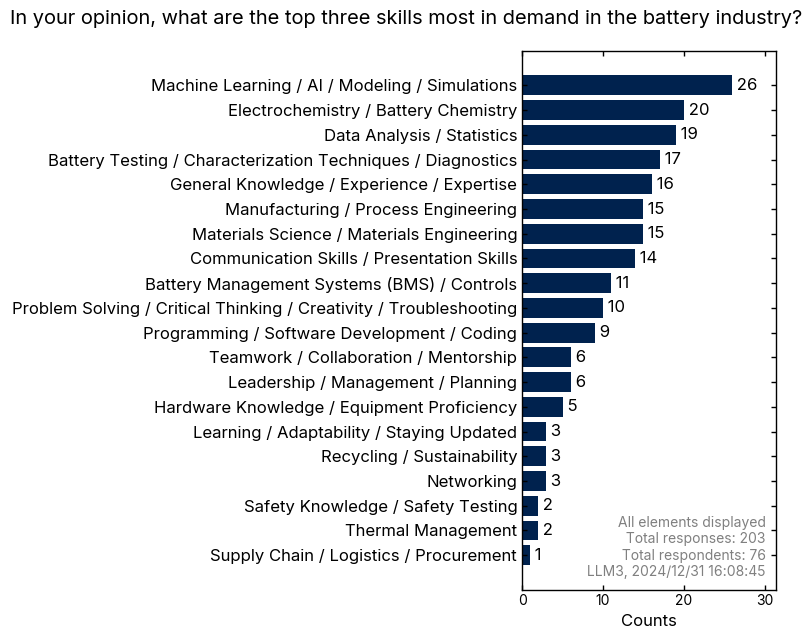

In [17]:
plotter.make_bar_plot_from_dict(counter,
                                title=question['question'],
                                sorted=True,
                                annotation=f'LLM3, {time.strftime("%Y/%m/%d %H:%M:%S")}',
                                num_elements=100,
                                saveas=f'{question['tag']}_students_{time.strftime("%Y%m%d_%H%M%S")}.png'
)